In [1]:
import gaia_roman_combined as grc

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

font = {'family' : 'serif',
        'size'   : 16,}
matplotlib.rc('font', **font)

import astropy
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u



In [2]:
#define some default values

roman_pos_floor_err = 0.01*grc.roman_pix_scale #mas, floor or pos uncertainty, (standard is 1% pixel)
gaia_era = 'DR4' #choose from ['DR3','DR4','DR5']

roman_background = 'hlwas-medium_field1'
roman_background_level = 'medium'

In [3]:
print(f'Currently Using a Roman position uncertainty floor of {roman_pos_floor_err} mas')

print()

print('Allowed Roman filters are:',grc.allowed_filters)

print()
print('Allowed Roman background choices are:\n',grc.allowed_backgrounds)
print()
print('Allowed Roman background level choices are:',grc.allowed_background_levels)

print()
print('Allowed Roman MultiAccum choices are:')
print('#MA_Name            Exposure Time (seconds)')
for ma_name in grc.allowed_ma_names:
    print(f'{ma_name:20s}{round(grc.ma_integration_times[ma_name],1)}')


Currently Using a Roman position uncertainty floor of 1.078577405 mas

Allowed Roman filters are: ['F062', 'F087', 'F106', 'F129', 'F146', 'F158', 'F184', 'F213']

Allowed Roman background choices are:
 ['hltds', 'gbtds_mid_5stripe', 'hlwas-medium_field1', 'hlwas-medium_field2', 'hlwas-wide_field1', 'hlwas-wide_field2', 'hlwas-wide_field3', 'hlwas-wide_field4']

Allowed Roman background level choices are: ['medium']

Allowed Roman MultiAccum choices are:
#MA_Name            Exposure Time (seconds)
IM_60_6_S           60
IM_66_6             66
IM_76_7_S           76
IM_85_7             85
IM_95_7             95
IM_101_7            101
IM_107_7            107
IM_107_8_S          107
IM_120_8            120
IM_135_8            135
IM_152_9            152
IM_171_10           171
IM_193_11           193
IM_193_14_S         193
IM_225_13           225
IM_250_14           250
IM_284_14           284
IM_294_16           294
IM_307_16           307
IM_360_16           360
IM_409_16           40

In [4]:
'''
Example of how to measure the improved astrometry from combining Roman and Gaia.
The user must provide lists of Roman magnitudes (and corresponding filters),
Gaia magnitudes, and Roman observation plans (MJD, Roman filter, n_repeat_at_epoch).
'''

#example with 100 magnitudes
n_stars = 100
roman_filters = ['F106','F213'] #list of filters that we will have Roman observations for
n_filters = len(roman_filters)

#array that contains the Roman magnitudes in each filter.
#
roman_mags = np.zeros((n_stars,n_filters)) 
roman_mags[:,0] = np.linspace(16,26.5,n_stars)         #AB mags
roman_mags[:,1] = np.linspace(16,26.5,n_stars) + 0.1   #AB mags
#Gaia magnitudes (of same length as roman_mags).
#Again, this could be improved with isochrones to get
#better agreement between Roman and Gaia mags
gaia_mags = roman_mags[:,0] - 0.5 #Gaia G mags

#now set up the observing plan by listing the MJDs of each Roman epoch,
#the Roman filter at that epoch, and the number of repeat Roman 
#observations at that epoch

epoch_MJDs = Time([2028.0,2031.0,2031.5],format='jyear').mjd
epoch_filters = ['F213','F106','F213'] #filter for that observation
n_images_per_epoch = [4,3,4]
epoch_MAs = ['IM_193_11','IM_193_11','IM_193_11'] #Roman MultiAccum names for that observation (i.e. exposure times)

#build the observation list using the above data
observation_list = list(zip(epoch_MJDs,epoch_filters,n_images_per_epoch,epoch_MAs))

#Get the new precision from this configuration of
#magnitudes and observing plans. 
#NOTE: specifying ra and dec mean that parallax is used in 
#the calculation. Leaving the ra and dec as None will
#only use positions and PMs in the calculation.
new_precision = grc.gaia_roman_astrometric_precision(
    roman_mags = roman_mags,
    roman_filters = roman_filters,
    gaia_mags = gaia_mags,
    roman_pos_floor_err = roman_pos_floor_err,
    observation_list = observation_list,
    gaia_era = gaia_era,
    ra = 180.0, dec = 0.0,
    roman_background = roman_background,
    roman_background_level = roman_background_level,
)

/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 3 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/anaconda3/envs/latest_test/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 3 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_2211/2584451031.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


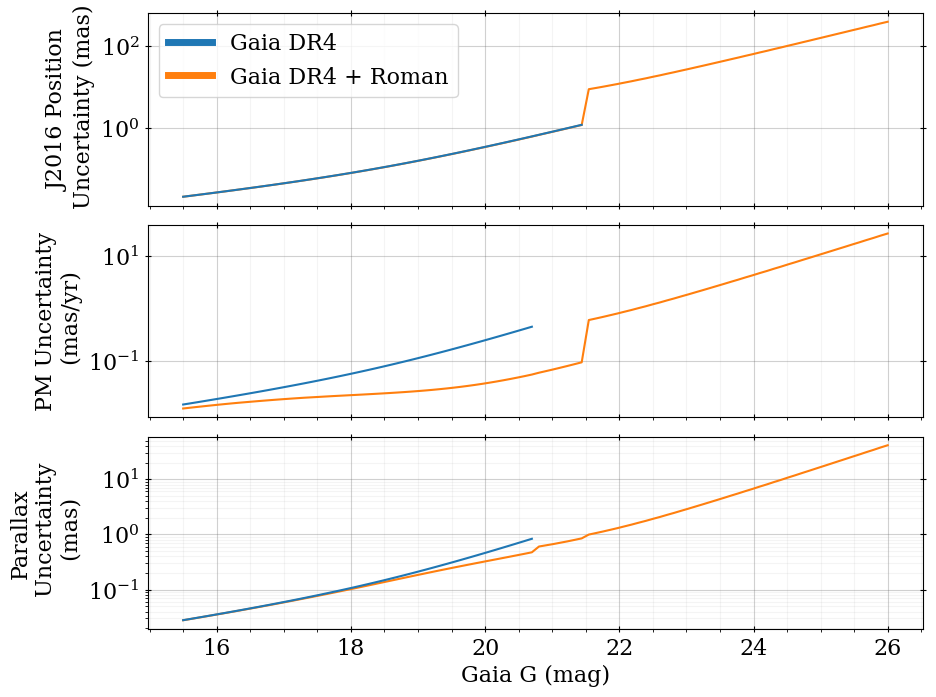

In [5]:
'''
Plot the new astrometric precision compared to Gaia
'''

plt.figure(figsize=(10,8))

gs = gridspec.GridSpec(3,1,hspace=0.1)
ax = plt.subplot(gs[0])    

ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_pos_errs,label=f'Gaia {new_precision.gaia_era}',zorder=10)
plt.plot(new_precision.gaia_gs,new_precision.final_pos_errs,label=f'Gaia {new_precision.gaia_era} + Roman')
# plt.xlabel('Gaia G (mag)')
plt.ylabel('J2016 Position\n Uncertainty (mas)')
leg = plt.legend(loc='best')
for line in leg.get_lines():
    line.set_linewidth(5.0)
ax.set_xticklabels([])
xlim = plt.xlim()

ax = plt.subplot(gs[1])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_pm_errs,label=f'Gaia {new_precision.gaia_era}',zorder=10)
plt.plot(new_precision.gaia_gs,new_precision.final_pm_errs,label=f'Gaia {new_precision.gaia_era} + Roman')
# plt.xlabel('Gaia G (mag)')
plt.xlim(xlim)
plt.ylabel('PM Uncertainty\n (mas/yr)')
ax.set_xticklabels([])

ax = plt.subplot(gs[2])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_parallax_errs,label=f'Gaia {new_precision.gaia_era}',zorder=10)
plt.plot(new_precision.gaia_gs,new_precision.final_parallax_errs,label=f'Gaia {new_precision.gaia_era} + Roman')
plt.xlim(xlim)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Parallax\n Uncertainty\n (mas)')
plt.tight_layout()
plt.show()



/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_2211/3824989757.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


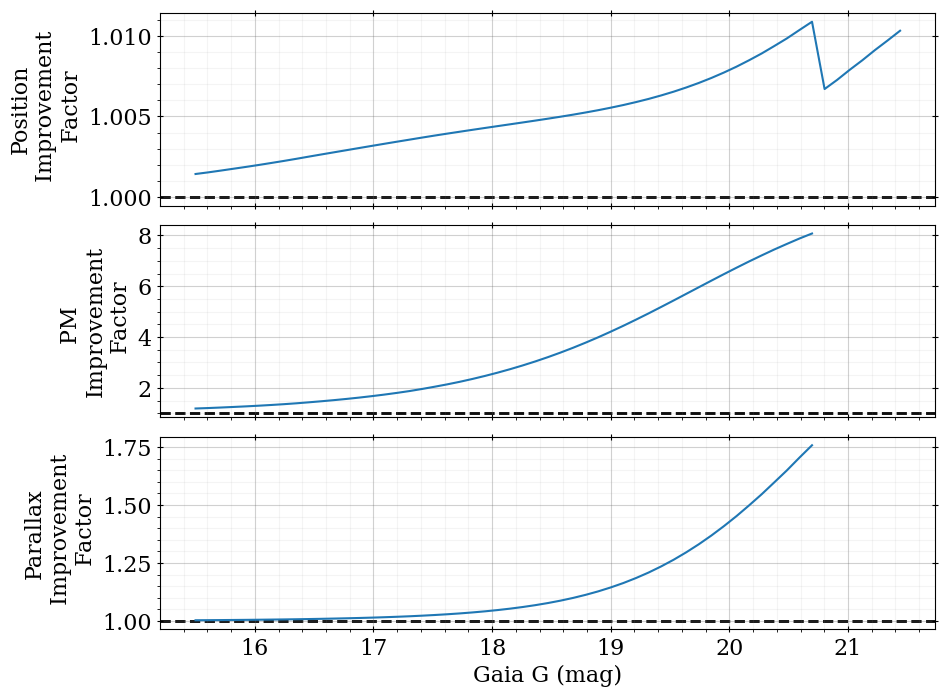

In [6]:
'''
Compare the improvement in astrometric precision over Gaia alone 
(i.e. Gaia Uncertainty / New Uncertainty)
'''


plt.figure(figsize=(10,8))

gs = gridspec.GridSpec(3,1,hspace=0.1)
ax = plt.subplot(gs[0])    

plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_pos_errs/new_precision.final_pos_errs)
# plt.xlabel('Gaia G (mag)')
plt.axhline(1.0,c='k',lw=2,ls='--',zorder=-1e10)
xlim = plt.xlim()
plt.ylabel('Position\n Improvement\n Factor')
ax.set_xticklabels([])

ax = plt.subplot(gs[1])    
# ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_pm_errs/new_precision.final_pm_errs)
# plt.xlabel('Gaia G (mag)')
plt.axhline(1.0,c='k',lw=2,ls='--',zorder=-1e10)
plt.xlim(xlim)
plt.ylabel('PM \nImprovement\n Factor')
ax.set_xticklabels([])

ax = plt.subplot(gs[2])    
# ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_parallax_errs/new_precision.final_parallax_errs)
plt.axhline(1.0,c='k',lw=2,ls='--',zorder=-1e10)
plt.xlim(xlim)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Parallax\n Improvement\n Factor')
plt.tight_layout()
plt.show()




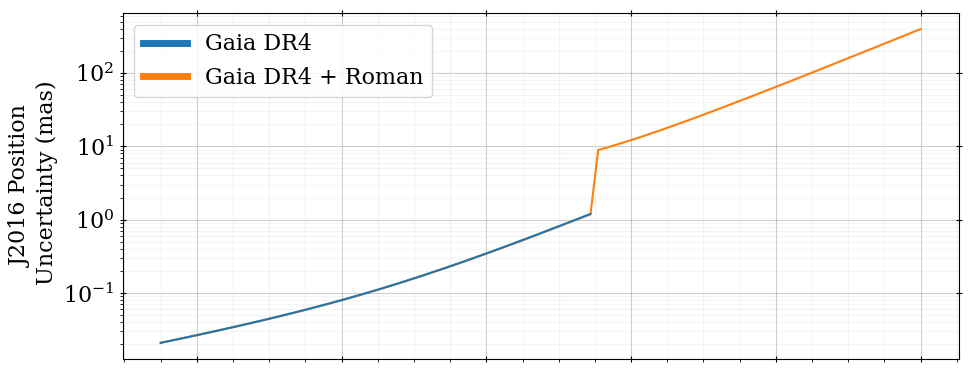

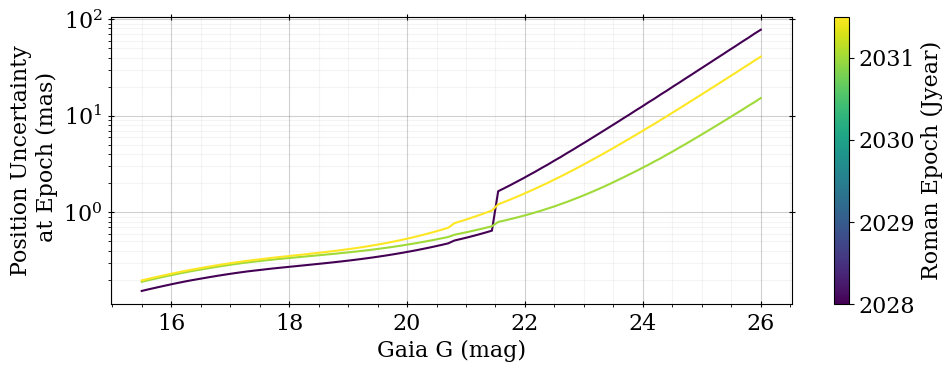

In [7]:
'''
Calculate the position uncertainty at each Roman observation epoch
'''


pos_covs_at_epochs = np.einsum('tij,tsjk->tsik',new_precision.motion_matrices,
          np.einsum('sij,tkj->tsik',new_precision.final_astrometry_covs,
                    new_precision.motion_matrices))
pos_errs_at_epochs = np.power(np.linalg.det(pos_covs_at_epochs),1/4)
obs_jyears = new_precision.obs_times.jyear

cmap = plt.cm.viridis
# create normalization instance
norm = matplotlib.colors.Normalize(vmin=obs_jyears.min(), vmax=obs_jyears.max())
# create a scalarmappable from the colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)    
sm.set_array([])  

plt.figure(figsize=(10,4))
ax = plt.gca()
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.gaia_pos_errs,label=f'Gaia {new_precision.gaia_era}',zorder=10)
plt.plot(new_precision.gaia_gs,new_precision.final_pos_errs,label=f'Gaia {new_precision.gaia_era} + Roman')
# plt.xlabel('Gaia G (mag)')
plt.ylabel('J2016 Position\n Uncertainty (mas)')
leg = plt.legend(loc='best')
for line in leg.get_lines():
    line.set_linewidth(5.0)
ax.set_xticklabels([])
xlim = plt.xlim()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,4))
ax = plt.gca()
ax.set_yscale('log')
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
for j in range(len(obs_jyears)):
    plt.plot(new_precision.gaia_gs,pos_errs_at_epochs[j],label='J%.1f'%obs_jyears[j],color=cmap(norm(obs_jyears[j])))
plt.colorbar(sm,ax=ax,label='Roman Epoch (Jyear)')
plt.xlim(xlim)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Position Uncertainty\n at Epoch (mas)')
plt.tight_layout()
plt.show()



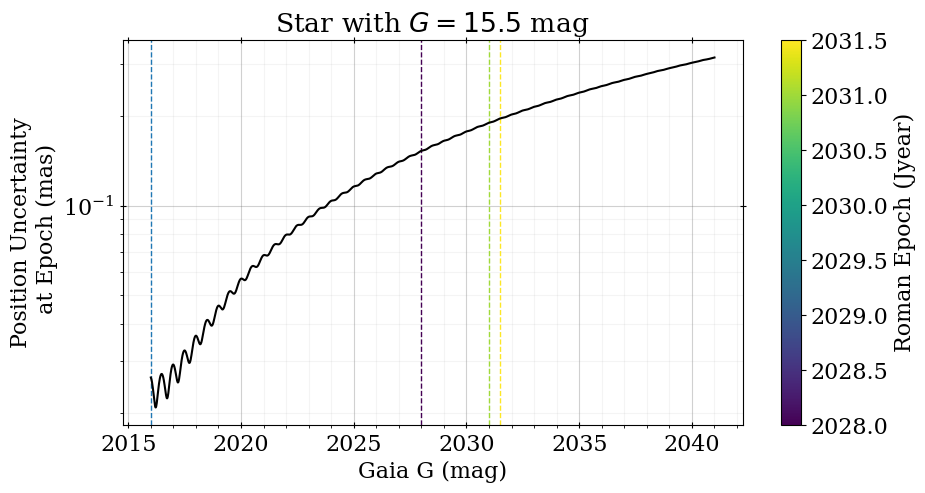

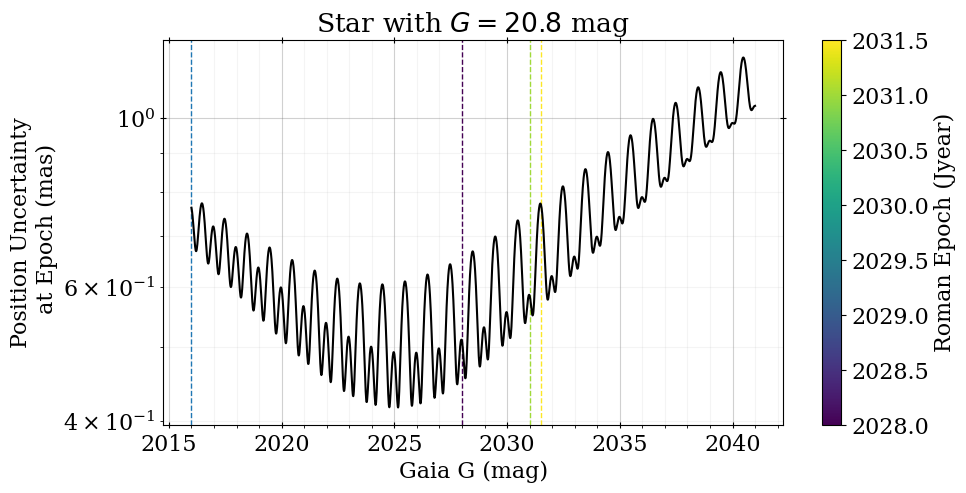

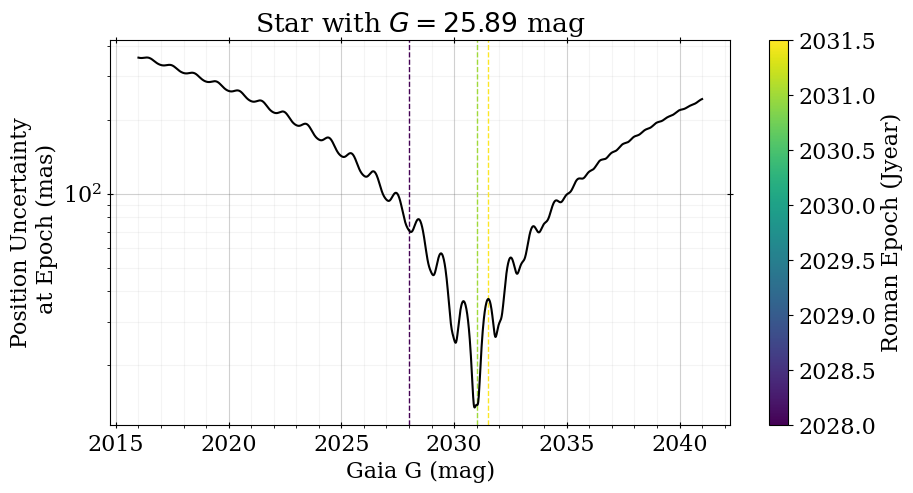

In [8]:
'''
Calculate position uncertainty as a function of time given the chosen observing conditions
'''

pos_errs_per_roman_epoch = (np.sqrt(np.power(new_precision.roman_pos_errs,2)\
                                    +(new_precision.roman_pos_floor_err)**2)[:,new_precision.obs_roman_filt_inds]\
                                    /np.sqrt(new_precision.obs_n_images_per_epoch[None,:]))
new_epoch_times = new_precision.gaia_time+np.linspace(0,25,2000)*u.year

new_motion_matrices = grc.create_motion_matrices(new_epoch_times,new_precision.gaia_time,
                                                 new_precision.ra,new_precision.dec,
                                                 return_only_motion=True)

new_pos_covs_at_epochs = np.einsum('tij,tsjk->tsik',new_motion_matrices,
          np.einsum('sij,tkj->tsik',new_precision.final_astrometry_covs,
                    new_motion_matrices))
new_pos_errs_at_epochs = np.power(np.linalg.det(new_pos_covs_at_epochs),1/4)
new_obs_jyears = new_epoch_times.jyear

for star_ind in [0,len(pos_errs_per_roman_epoch)//2,len(pos_errs_per_roman_epoch)-2]:
    plt.figure(figsize=(10,5))
    ax = plt.gca()
    ax.set_yscale('log')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
    ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
    
    for time_ind,time in enumerate(new_precision.obs_times.jyear):
        filt = new_precision.roman_filters[new_precision.obs_roman_filt_inds[time_ind]]
        plt.axvline(time,lw=1,ls='--',color=cmap(norm(time)))

    time_ind += 1
    time = new_precision.gaia_time.jyear
    if new_precision.good_gaia_pos[star_ind]:
        plt.axvline(time,lw=1,ls='--',color='C0')
        
    plt.colorbar(sm,ax=ax,label='Roman Epoch (Jyear)')

    
    plt.title(f'Star with $G = {round(new_precision.gaia_gs[star_ind],2)}$ mag')
    plt.plot(new_obs_jyears,new_pos_errs_at_epochs[:,star_ind],c='k')
    plt.xlabel('Gaia G (mag)')
    plt.ylabel('Position Uncertainty\n at Epoch (mas)')
    plt.show()
    


In [9]:
'''
Simulate adding in HST observations at different epochs.
Only considering on HST epoch is added
'''

n_hst_dithers = 4
hst_obs_times = Time(np.arange(2002,2025+1e-10,5),format='jyear')

hst_obs_times_jyear = hst_obs_times.jyear
cmap = plt.cm.viridis
# create normalization instance
norm = matplotlib.colors.Normalize(vmin=hst_obs_times_jyear.min(), vmax=hst_obs_times_jyear.max())
# create a scalarmappable from the colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)    
sm.set_array([])


#assuming a 1% pixel size uncertainty for all magnitudes
hst_pos_err = 0.01*50 #mas
hst_pos_cov = np.diag(np.ones(2)*hst_pos_err**2)
hst_pos_inv_cov = np.linalg.inv(hst_pos_cov)
obs_hst_inv_covs = hst_pos_inv_cov*n_hst_dithers

hst_obs_dyears = (hst_obs_times-new_precision.gaia_time).to(u.year).value

motion_matrices = grc.create_motion_matrices(hst_obs_times,new_precision.gaia_time,
                                                 new_precision.ra,new_precision.dec,
                                                 return_only_motion=True)


new_plot_dict = {}

for hst_ind in range(len(hst_obs_times)):
    motion_matrix = motion_matrices[hst_ind]
    n_fit_params = motion_matrix.shape[1]

    hst_data_inv_covs = np.dot(motion_matrix.T,np.dot(obs_hst_inv_covs,motion_matrix))
    new_astrometry_inv_covs = new_precision.final_astrometry_inv_covs + hst_data_inv_covs
    new_astrometry_covs = np.linalg.inv(new_astrometry_inv_covs)

    #use determinant definition of PM and Position error sizes
    new_pos_covs = new_astrometry_covs[:,:2,:2]
    new_pm_covs = new_astrometry_covs[:,2:4,2:4]
    if n_fit_params == 5:
        new_parallax_errs = np.sqrt(new_astrometry_covs[:,4,4])
    else:
        new_parallax_errs = new_precision.gaia_parallax_errs
    new_pos_errs = np.power(np.linalg.det(new_pos_covs),1/4)
    new_pm_errs = np.power(np.linalg.det(new_pm_covs),1/4)
    
    new_plot_dict['%d'%round(hst_obs_times[hst_ind].jyear)] = {
        'pos_errs':new_pos_errs,
        'parallax_errs':new_parallax_errs,
        'pm_errs':new_pm_errs,
        'plot_color':cmap(norm(hst_obs_times_jyear[hst_ind])),
                         }
        


/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_2211/3923433848.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


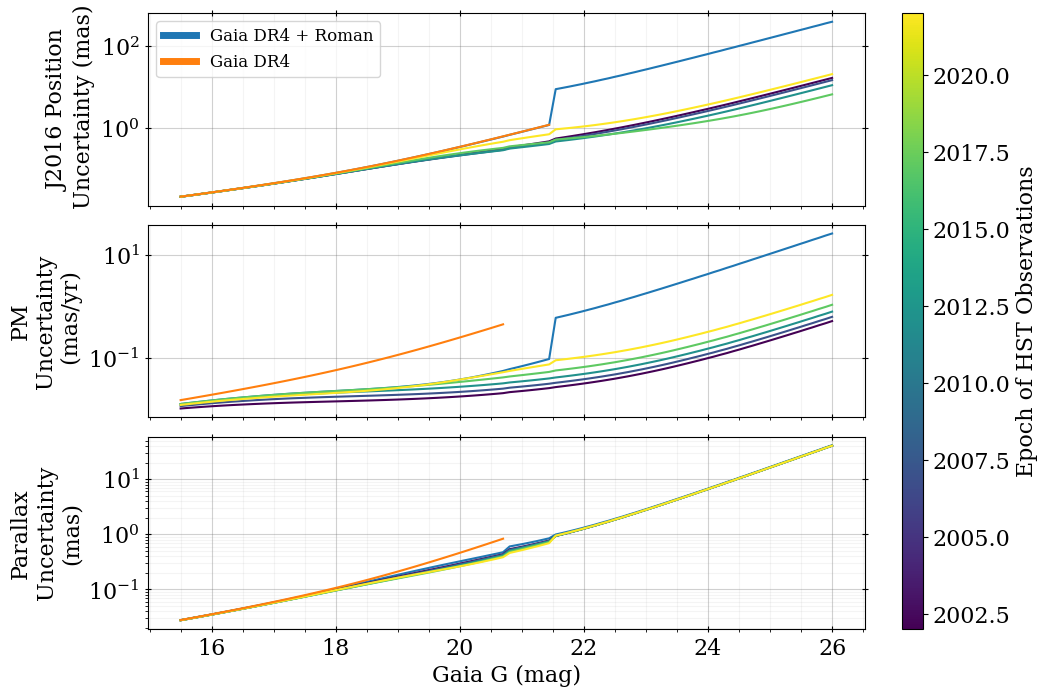

In [10]:


plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3,2,hspace=0.1,width_ratios=[1,0.03],wspace=0.1)
ax = plt.subplot(gs[0,0])    

# ax = plt.gca()
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.final_pos_errs,label=f'Gaia {new_precision.gaia_era} + Roman')
for new_key in new_plot_dict:
    keep_plot = (new_plot_dict[new_key]['pm_errs'] < 1e4)
    plt.plot(new_precision.gaia_gs[keep_plot],
             new_plot_dict[new_key]['pos_errs'][keep_plot],
             # label=new_key,
             color=new_plot_dict[new_key]['plot_color'])
plt.plot(new_precision.gaia_gs,new_precision.gaia_pos_errs,label=f'Gaia {new_precision.gaia_era}',zorder=100)
xlim = plt.xlim()
plt.ylabel('J2016 Position\n Uncertainty (mas)')
leg = plt.legend(loc=2,fontsize=12)
for line in leg.get_lines():
    line.set_linewidth(5.0)
ax.set_xticklabels([])


ax = plt.subplot(gs[1,0])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.final_pm_errs,label=f'Gaia {new_precision.gaia_era} + Roman')
for new_key in new_plot_dict:
    keep_plot = (new_plot_dict[new_key]['pm_errs'] < 1e4)
    plt.plot(new_precision.gaia_gs[keep_plot],
             new_plot_dict[new_key]['pm_errs'][keep_plot],
             # label=new_key,
             color=new_plot_dict[new_key]['plot_color'])
plt.plot(new_precision.gaia_gs,new_precision.gaia_pm_errs,label=f'Gaia {new_precision.gaia_era}',zorder=100)
plt.xlim(xlim)
plt.ylabel('PM\nUncertainty\n (mas/yr)')
ax.set_xticklabels([])

ax = plt.subplot(gs[2,0])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.plot(new_precision.gaia_gs,new_precision.final_parallax_errs,label=f'Gaia {new_precision.gaia_era} + Roman')
for new_key in new_plot_dict:
    keep_plot = (new_plot_dict[new_key]['pm_errs'] < 1e4)
    plt.plot(new_precision.gaia_gs[keep_plot],
             new_plot_dict[new_key]['parallax_errs'][keep_plot],
             # label=new_key,
             color=new_plot_dict[new_key]['plot_color'])
plt.plot(new_precision.gaia_gs,new_precision.gaia_parallax_errs,label=f'Gaia {new_precision.gaia_era}',zorder=100)
plt.xlim(xlim)
plt.xlabel('Gaia G (mag)')
plt.ylabel('Parallax\nUncertainty\n(mas)')

plt.colorbar(sm,cax=plt.subplot(gs[:,1]),
             label='Epoch of HST Observations')

plt.tight_layout()
plt.show()


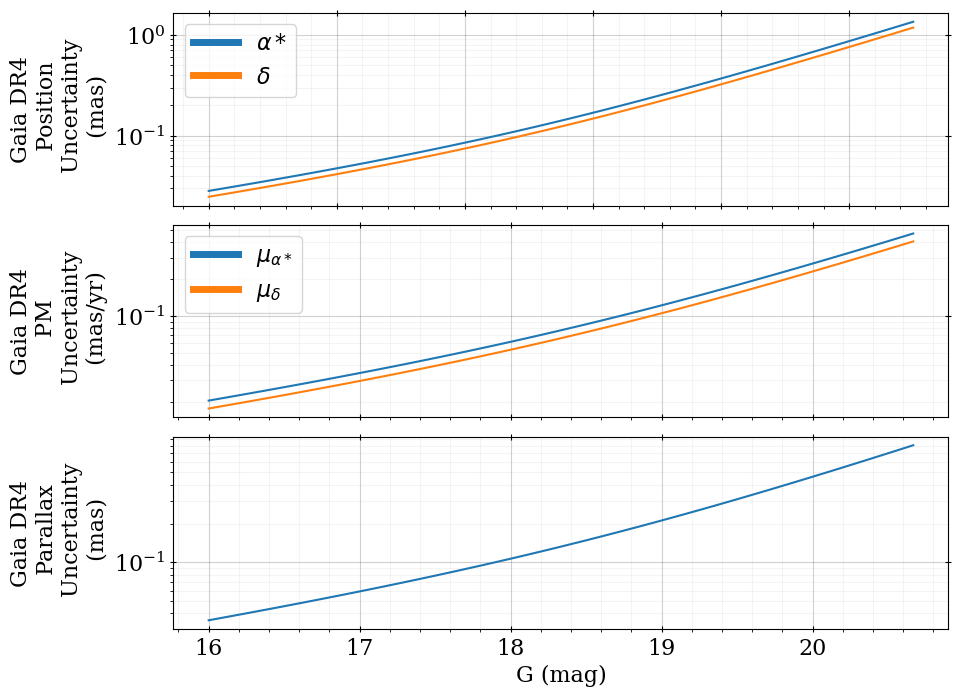

In [11]:
'''
Plot size of Gaia astrometric precision for a chosen gaia data release era
'''

gmags = np.linspace(16,21.5,100)
gaia_precision = grc.gaia_astrometry_precision(gmags,era=gaia_era)

plt.figure(figsize=(10,8))

gs = gridspec.GridSpec(3,1,hspace=0.1)
ax = plt.subplot(gs[0])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
ax.set_xticklabels([])
plt.ylabel(f'Gaia {gaia_era}\n Position\n Uncertainty\n (mas)')
plt.plot(gmags,gaia_precision[0],label=r'$\alpha*$')
plt.plot(gmags,gaia_precision[1],label=r'$\delta$')
leg = plt.legend(loc='best')
for line in leg.get_lines():
    line.set_linewidth(5.0)

ax = plt.subplot(gs[1])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
ax.set_xticklabels([])
plt.ylabel(f'Gaia {gaia_era}\n PM\n Uncertainty\n (mas/yr)')
plt.plot(gmags,gaia_precision[2],label=r'$\mu_{\alpha*}$')
plt.plot(gmags,gaia_precision[3],label=r'$\mu_{\delta}$')
leg = plt.legend(loc='best')
for line in leg.get_lines():
    line.set_linewidth(5.0)

ax = plt.subplot(gs[2])    
ax.set_yscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
plt.xlabel('G (mag)')
plt.ylabel(f'Gaia {gaia_era}\n Parallax\n Uncertainty\n (mas)')
plt.plot(gmags,gaia_precision[4])
plt.show()


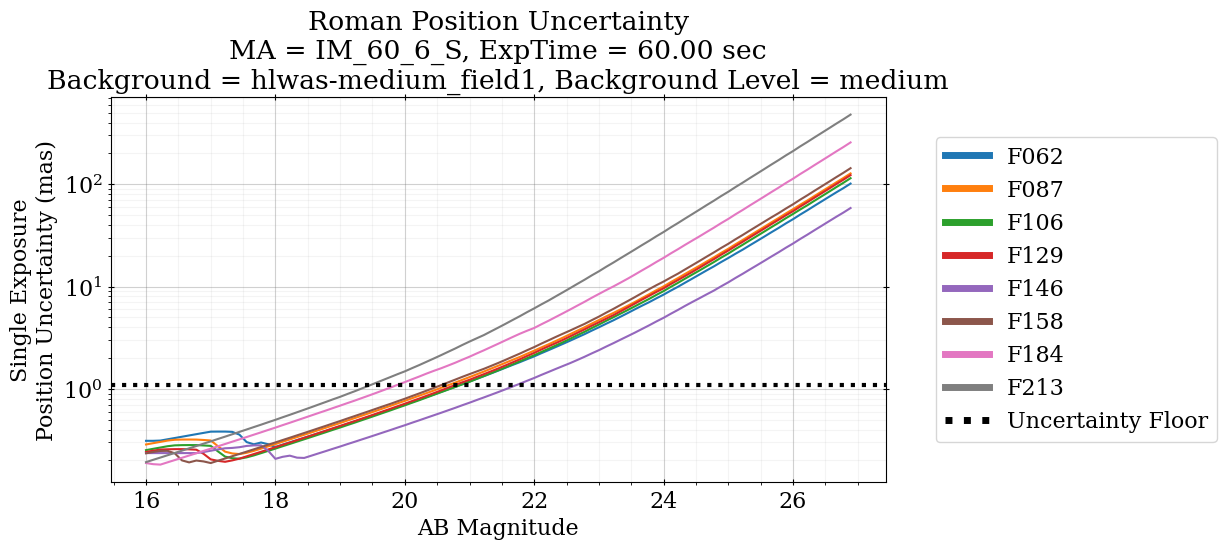

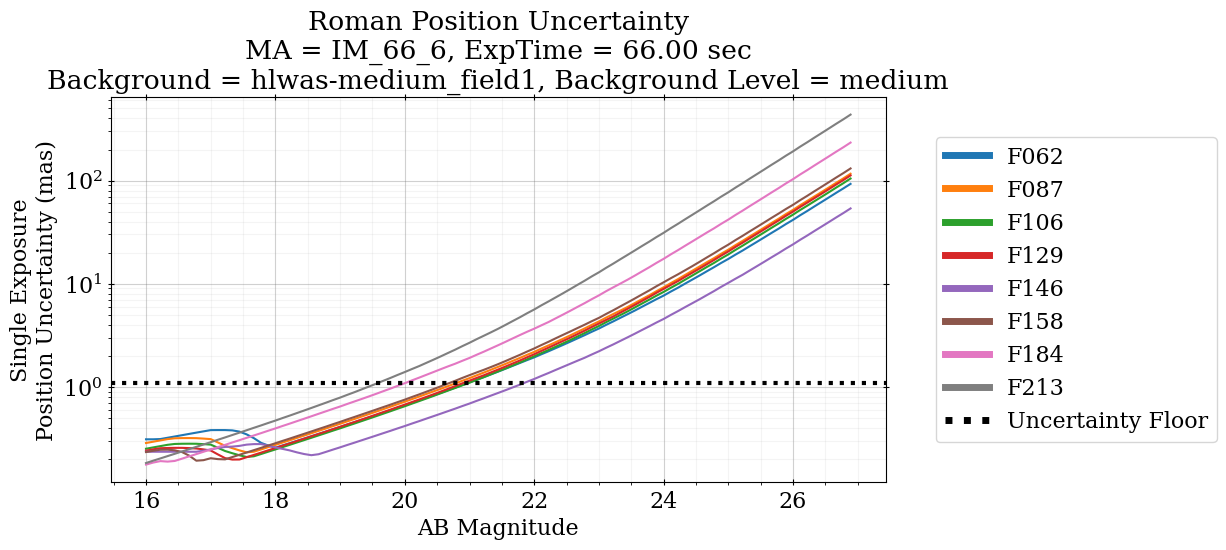

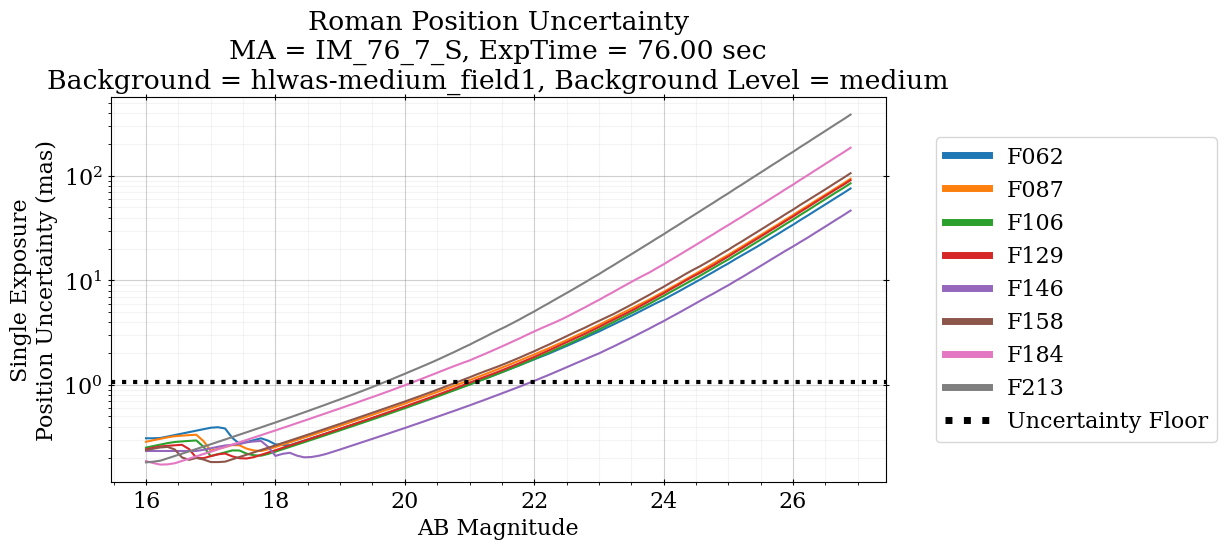

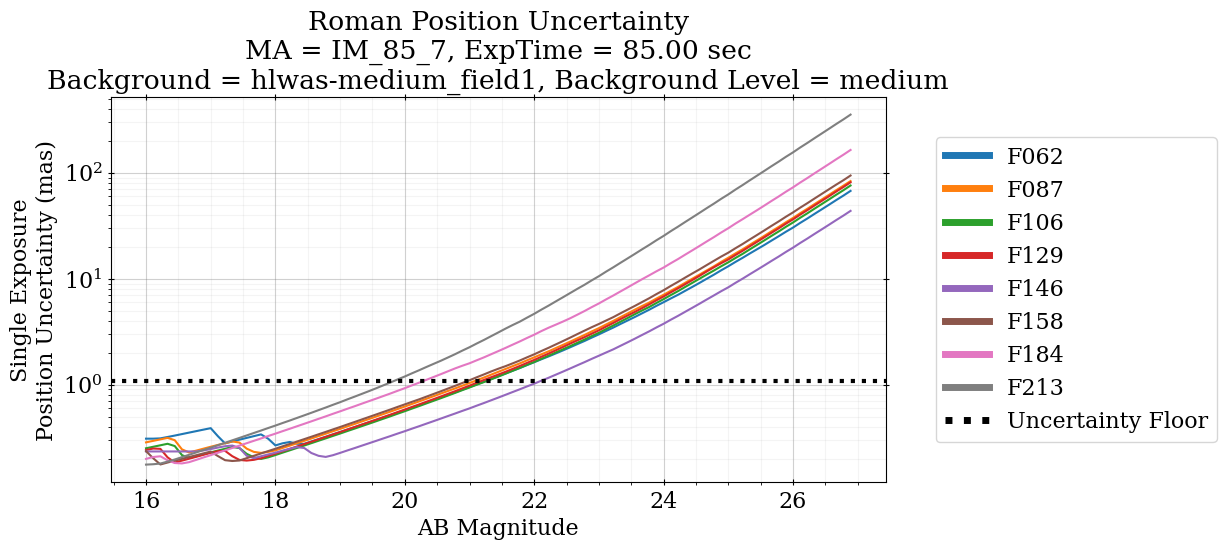

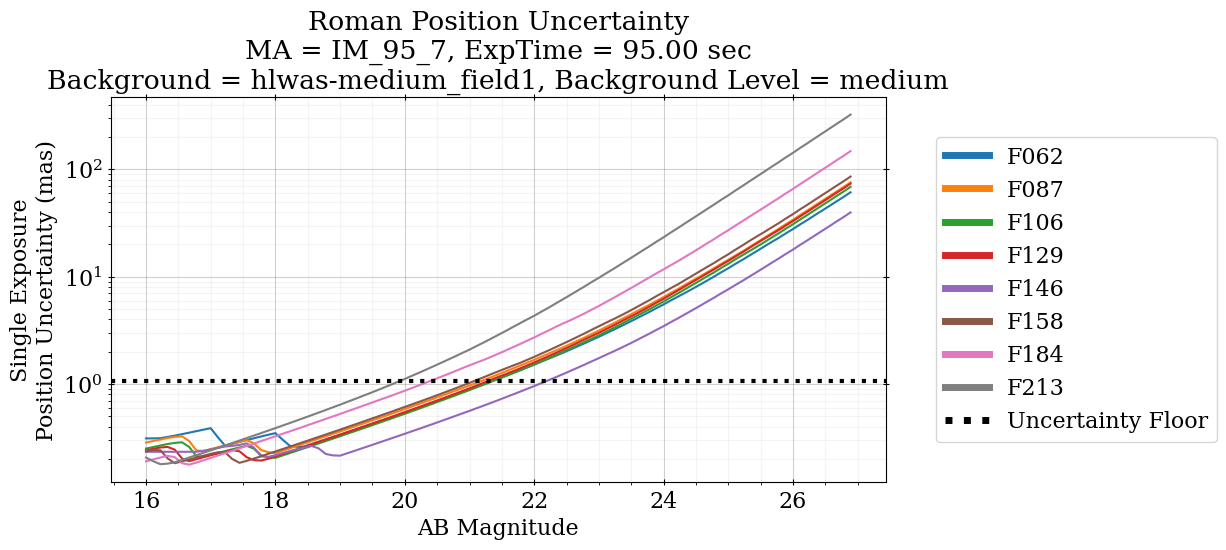

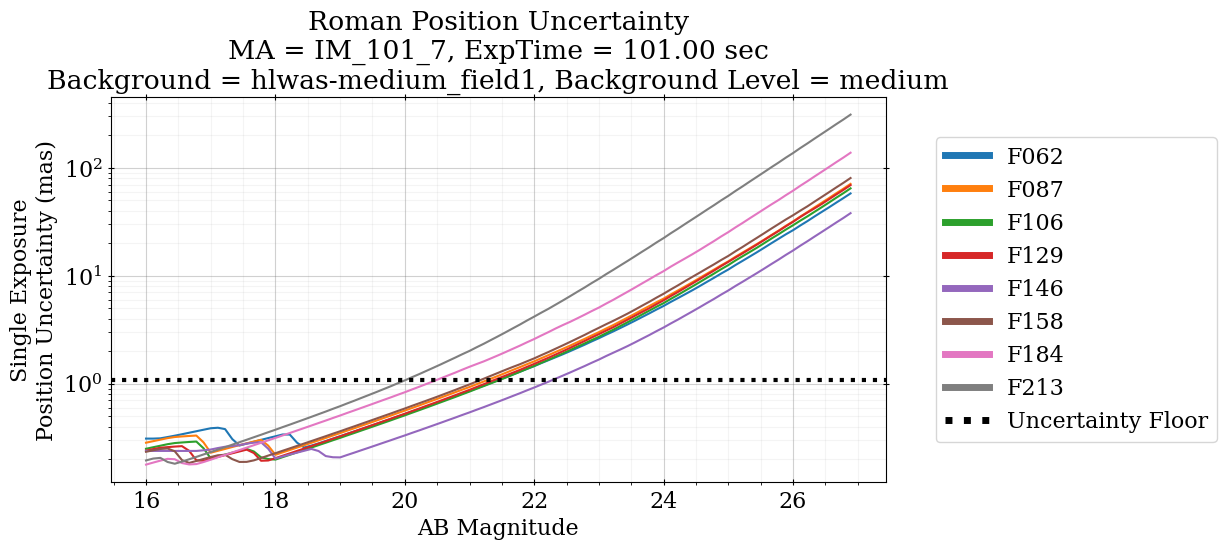

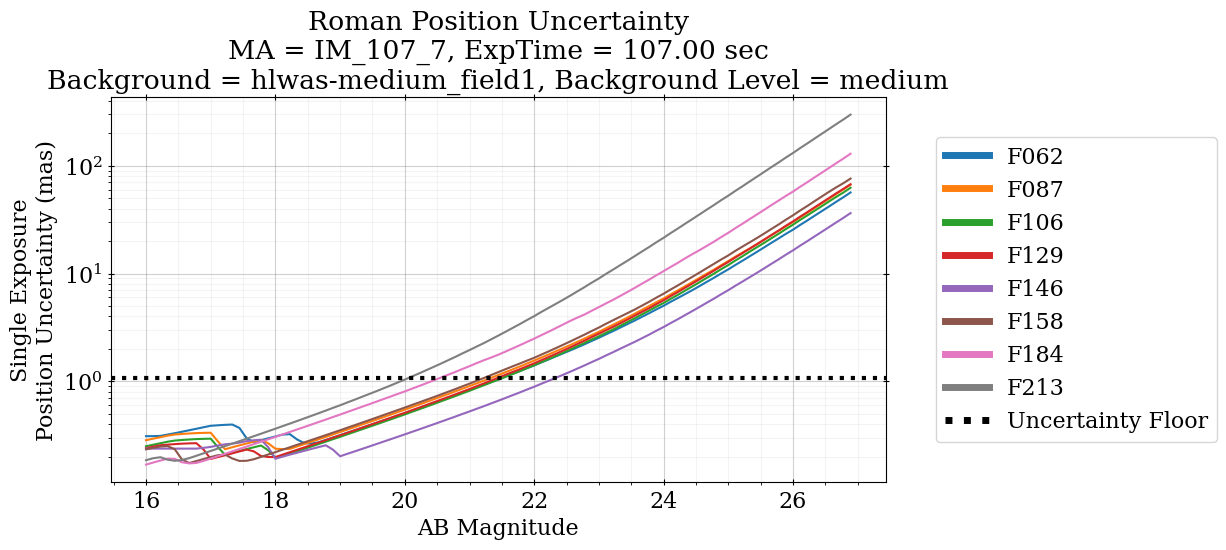

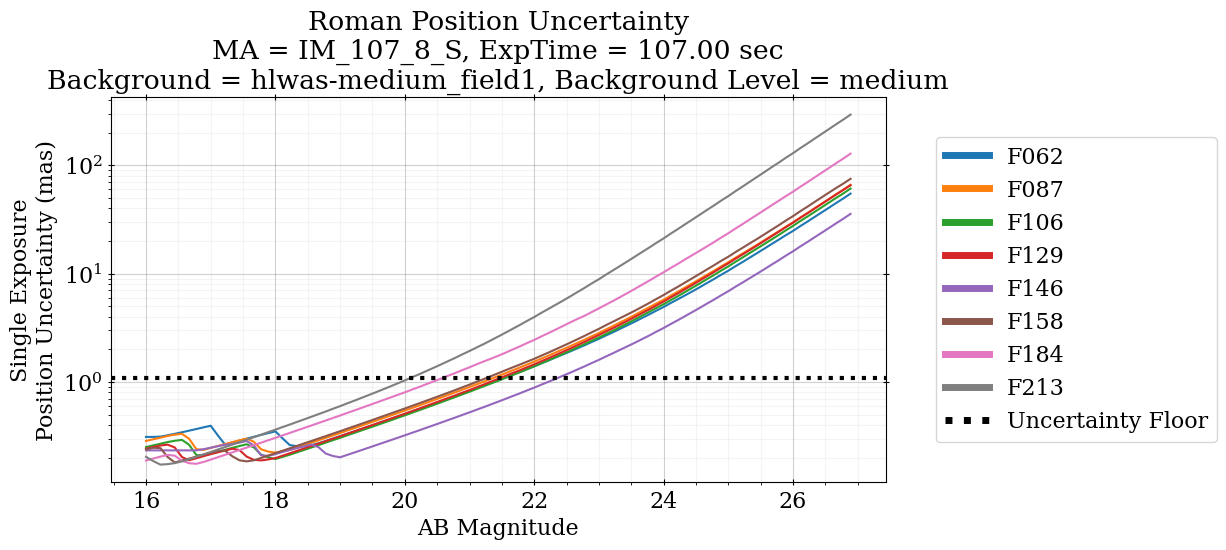

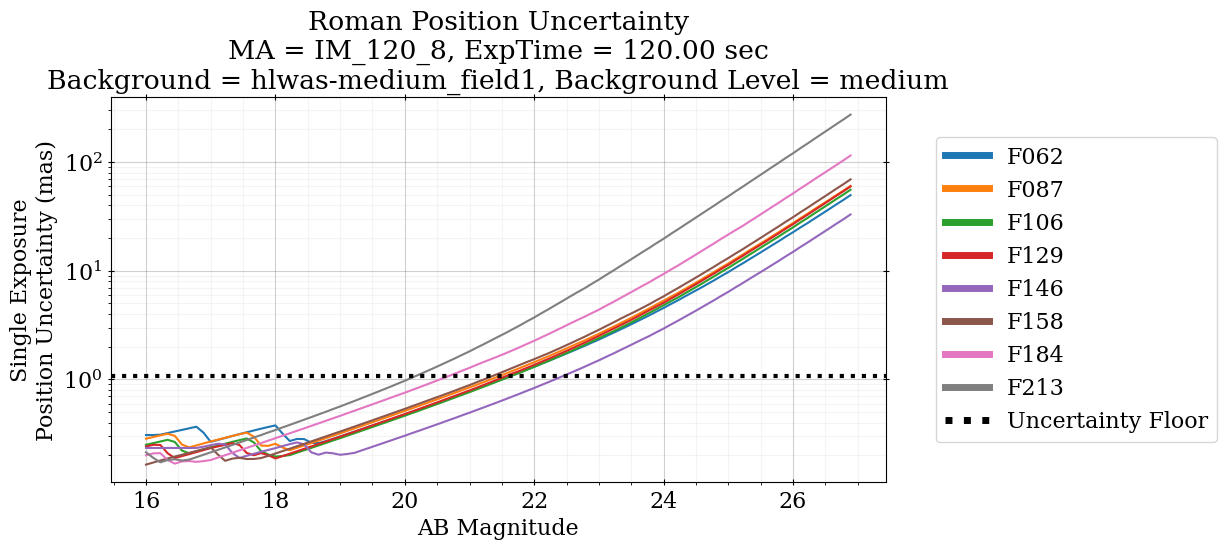

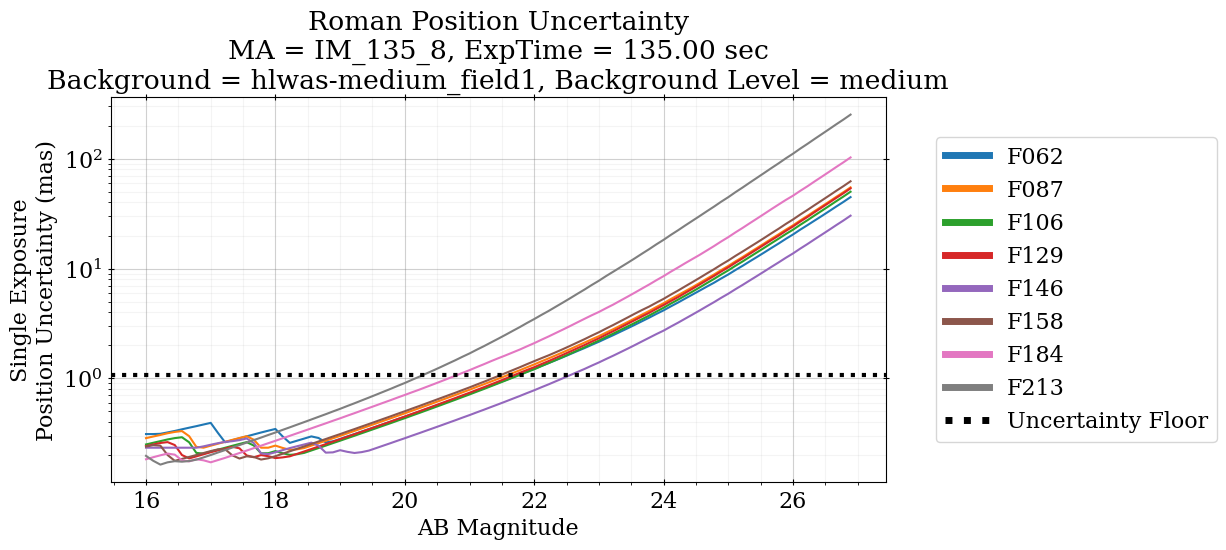

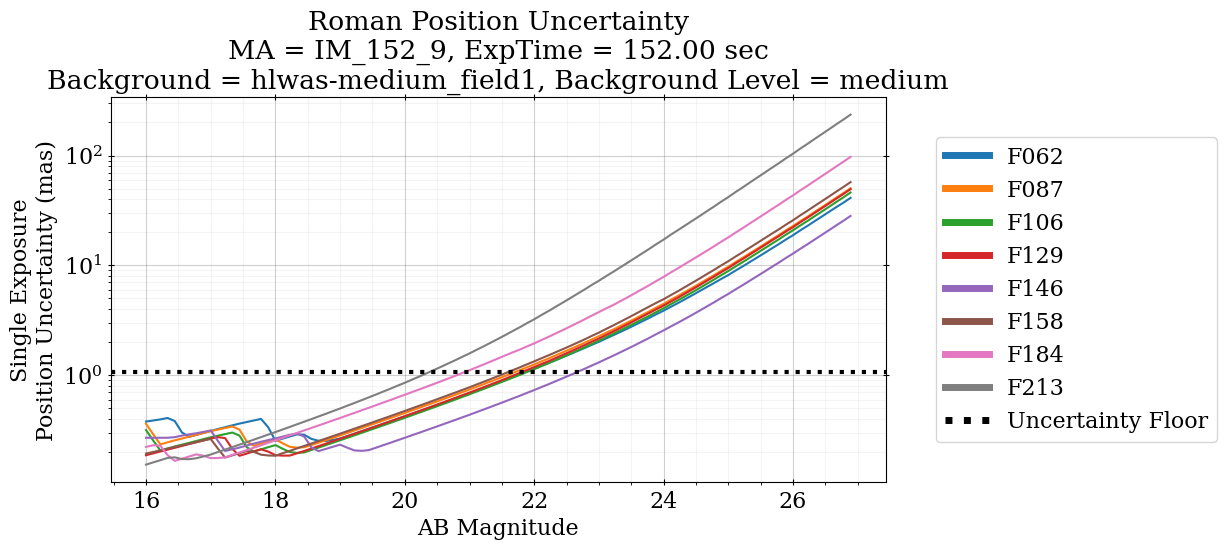

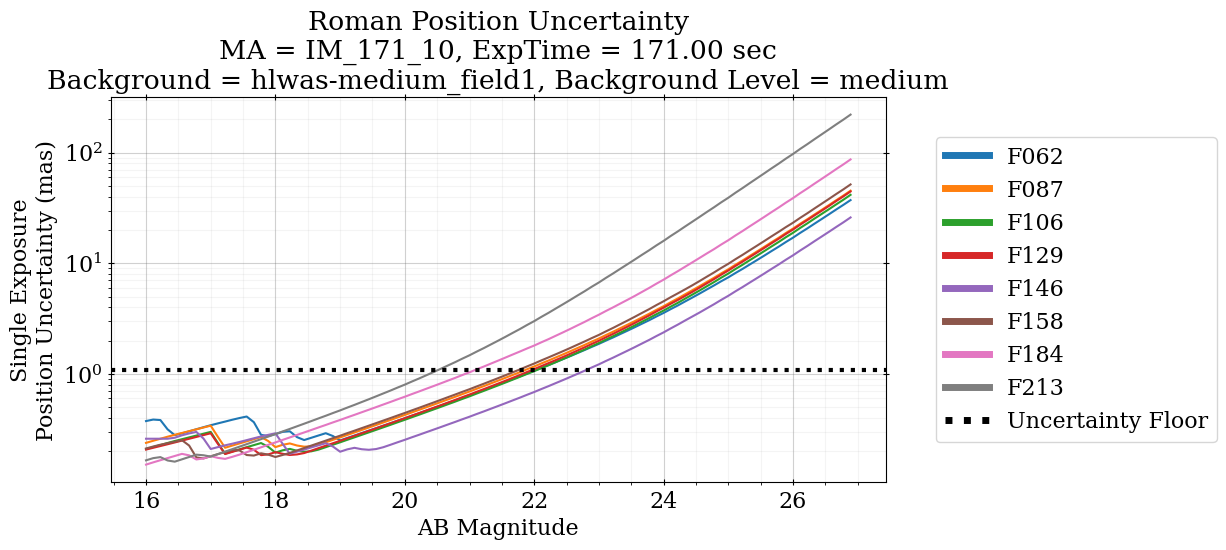

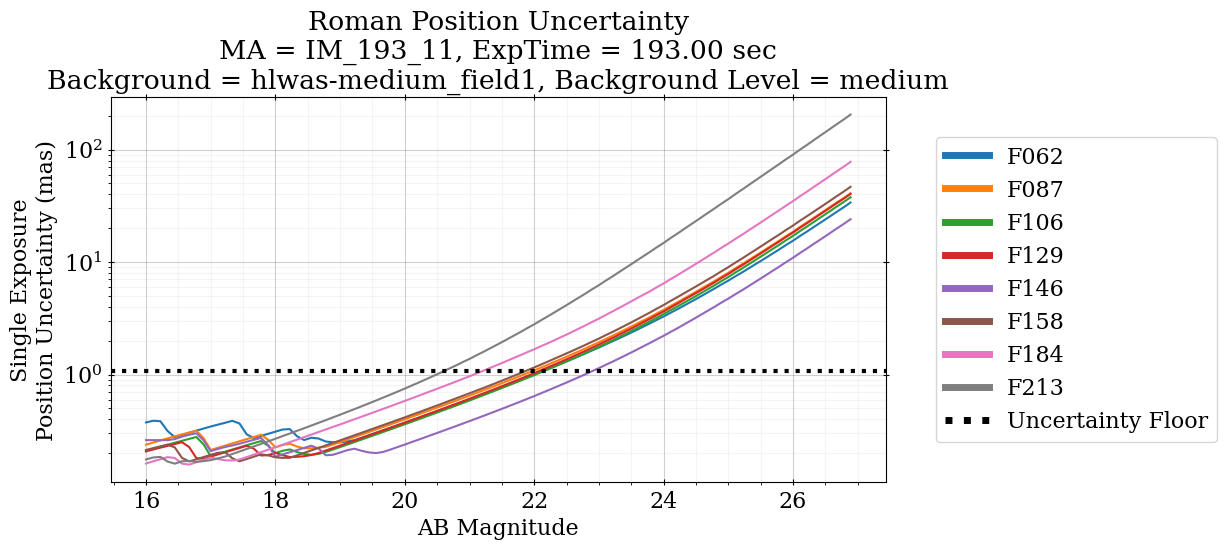

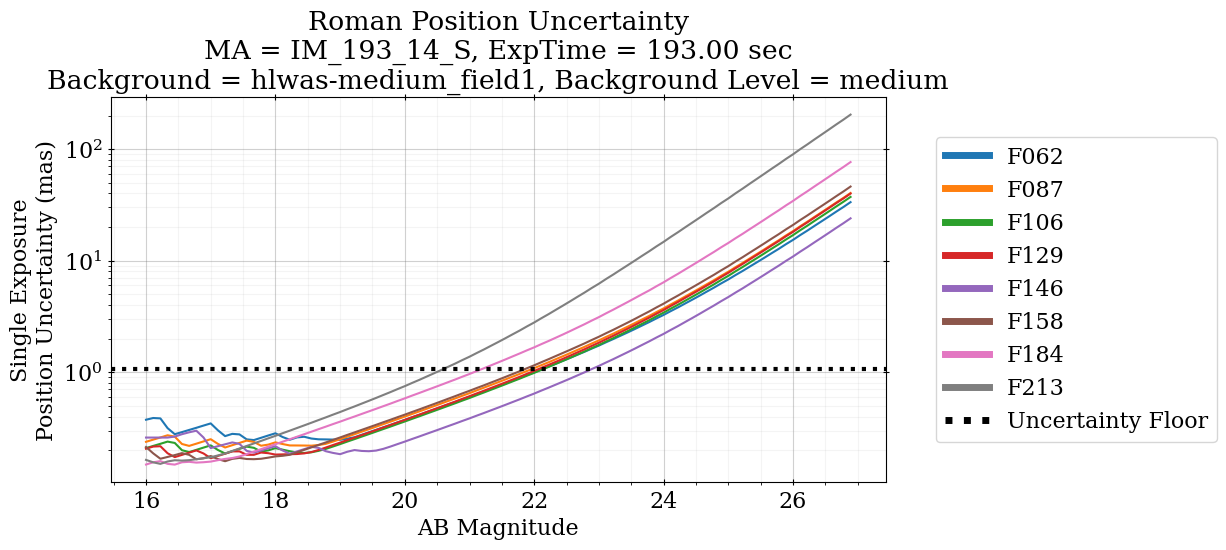

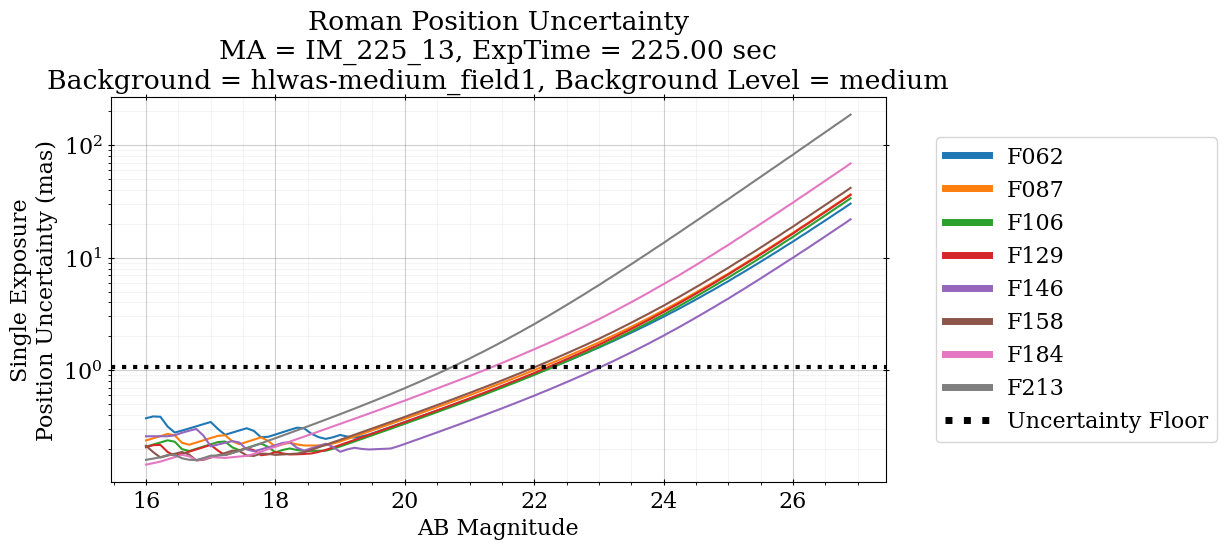

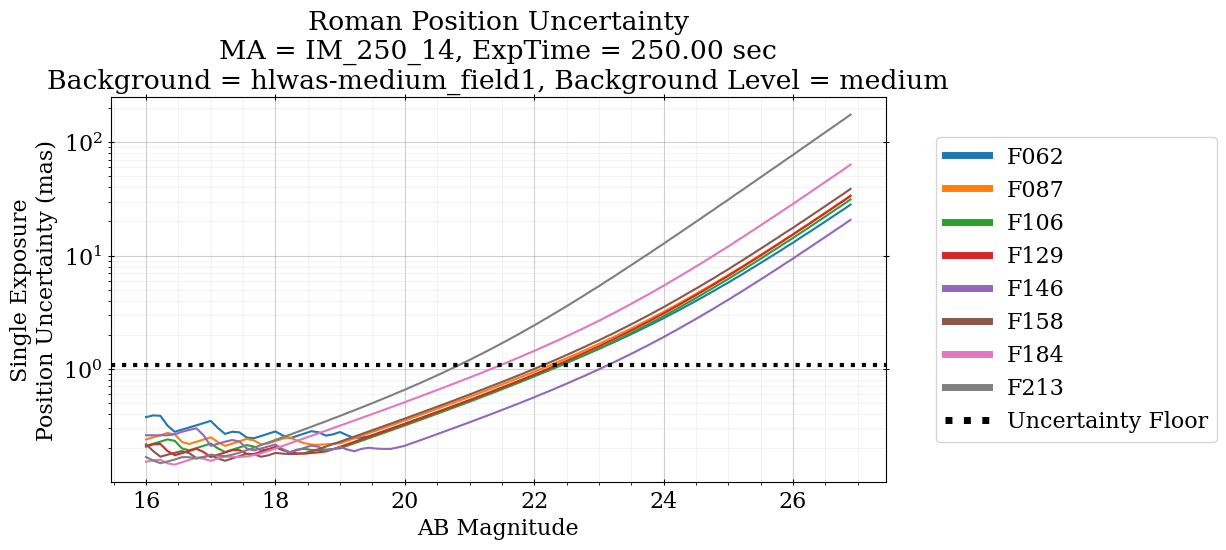

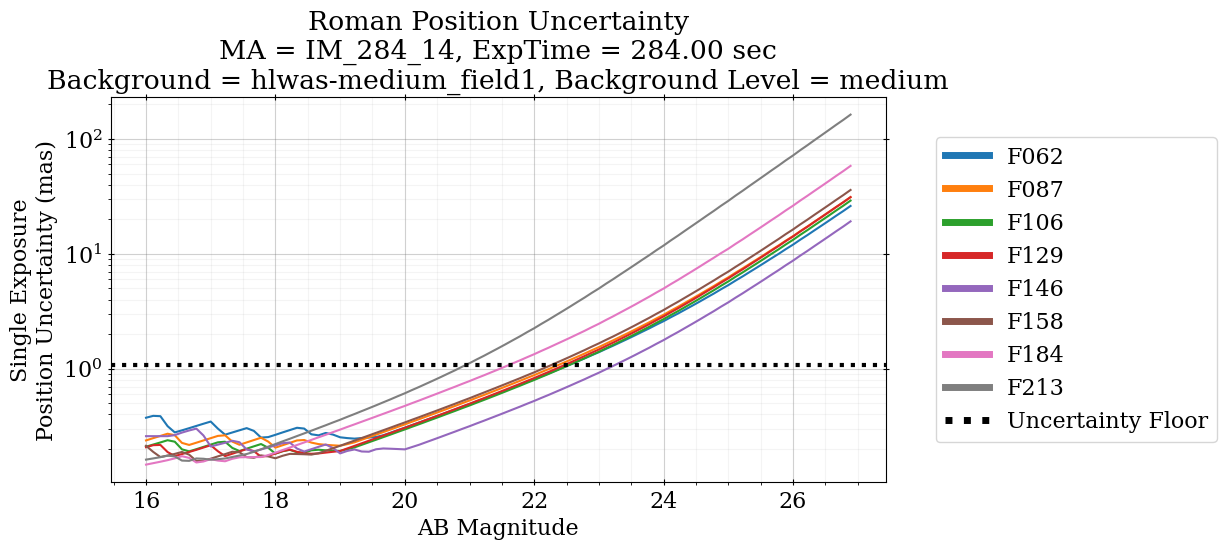

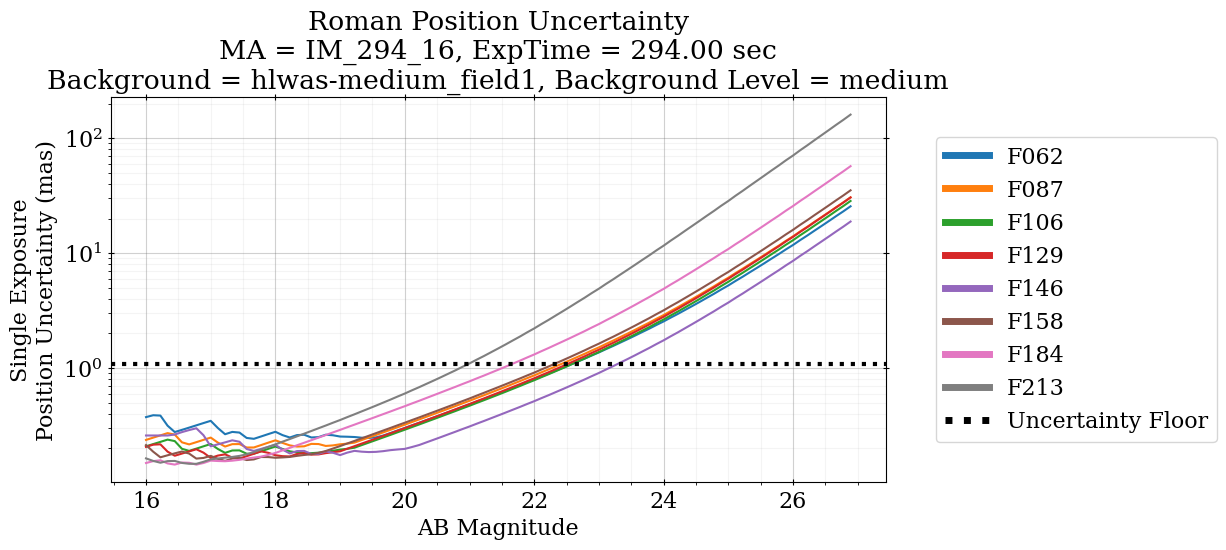

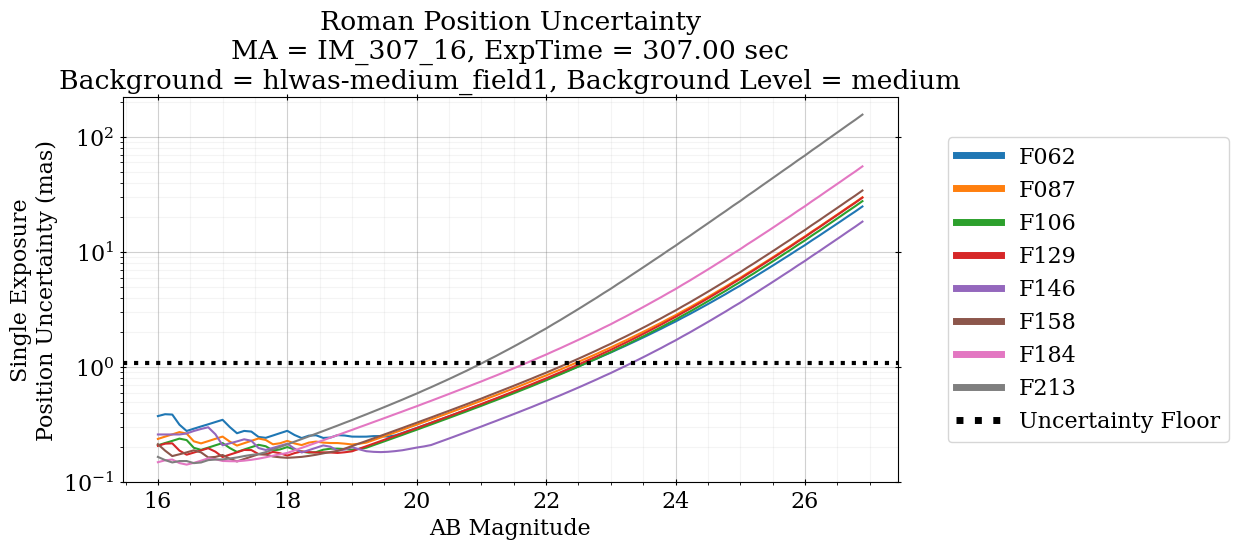

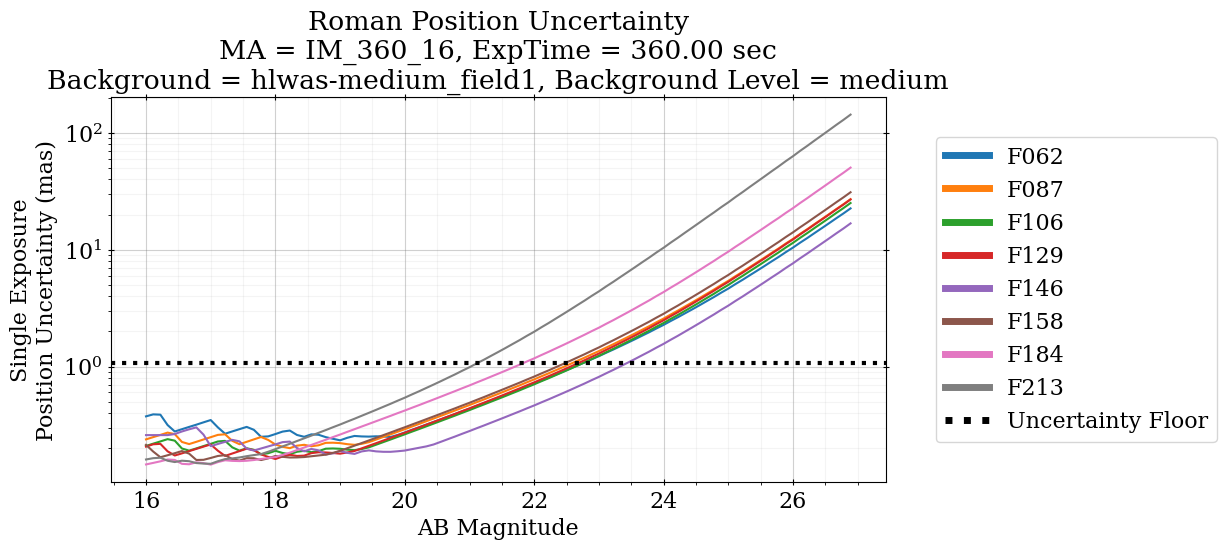

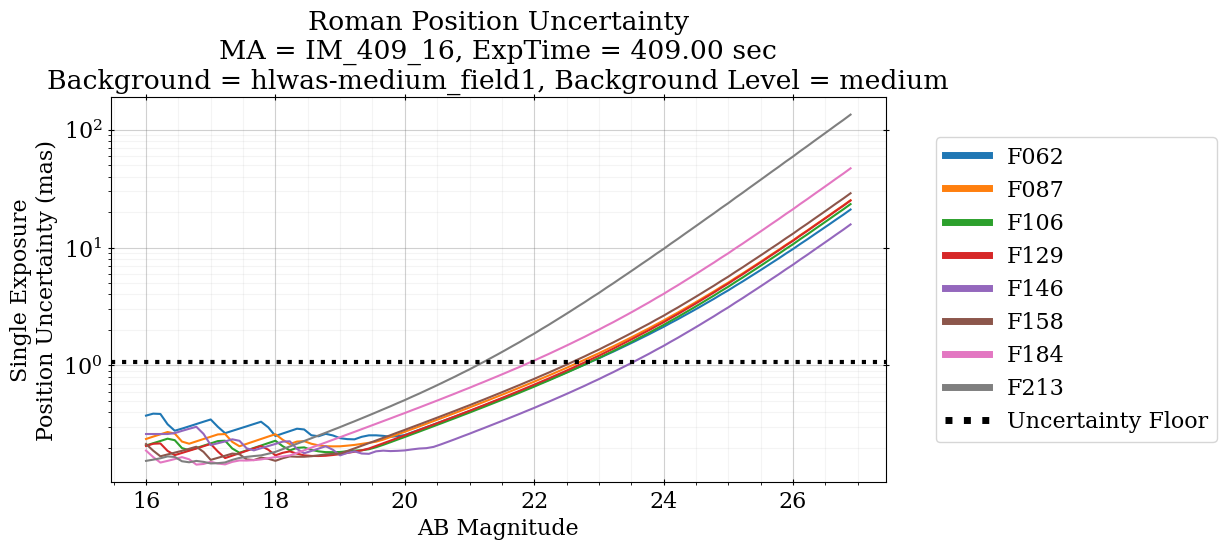

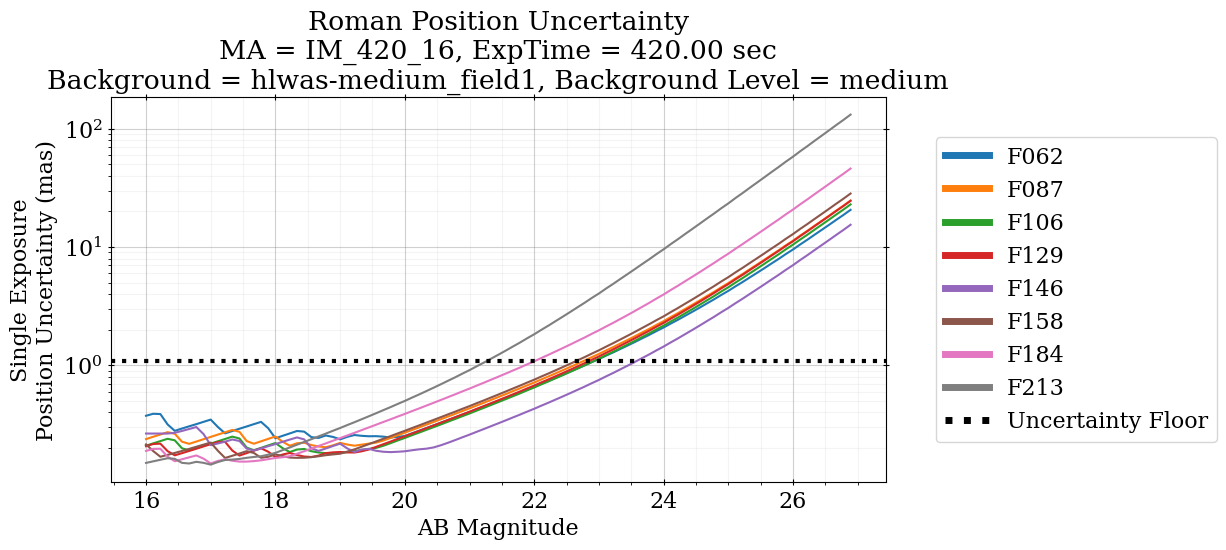

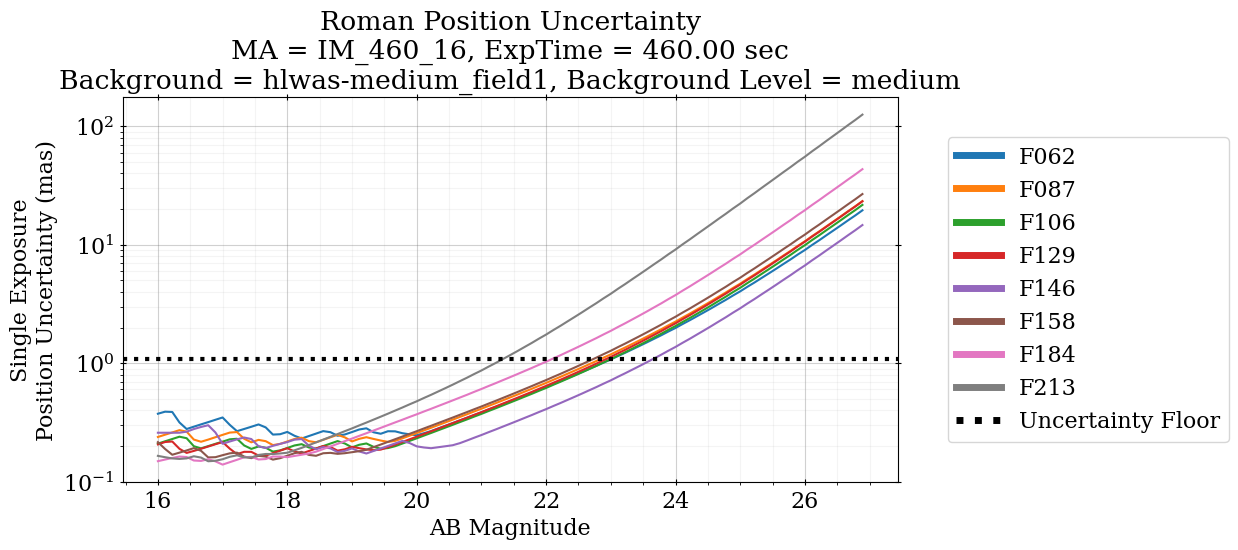

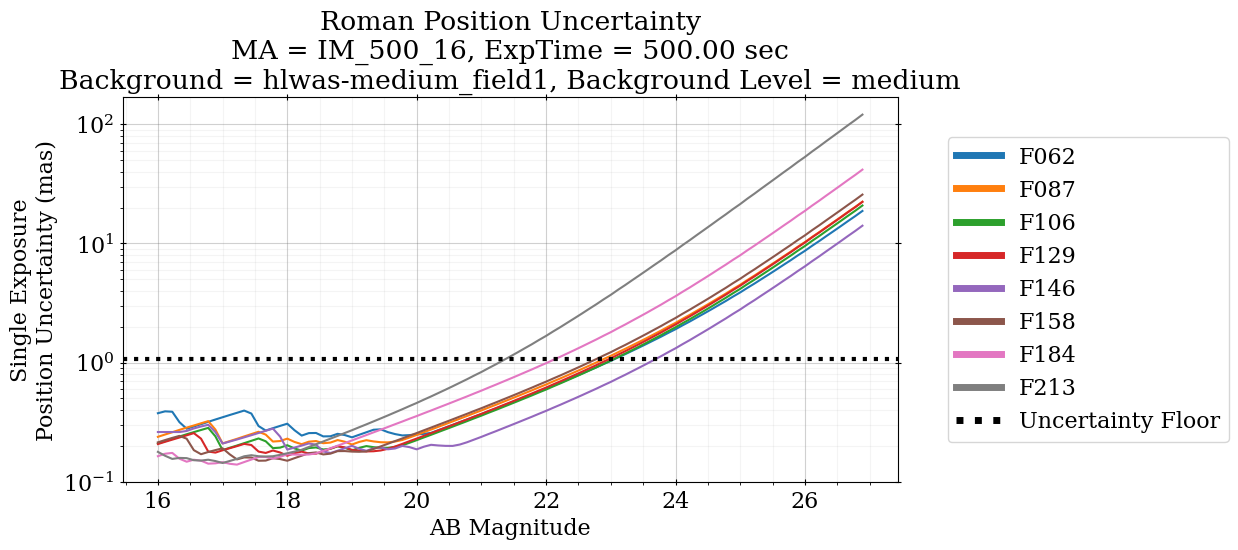

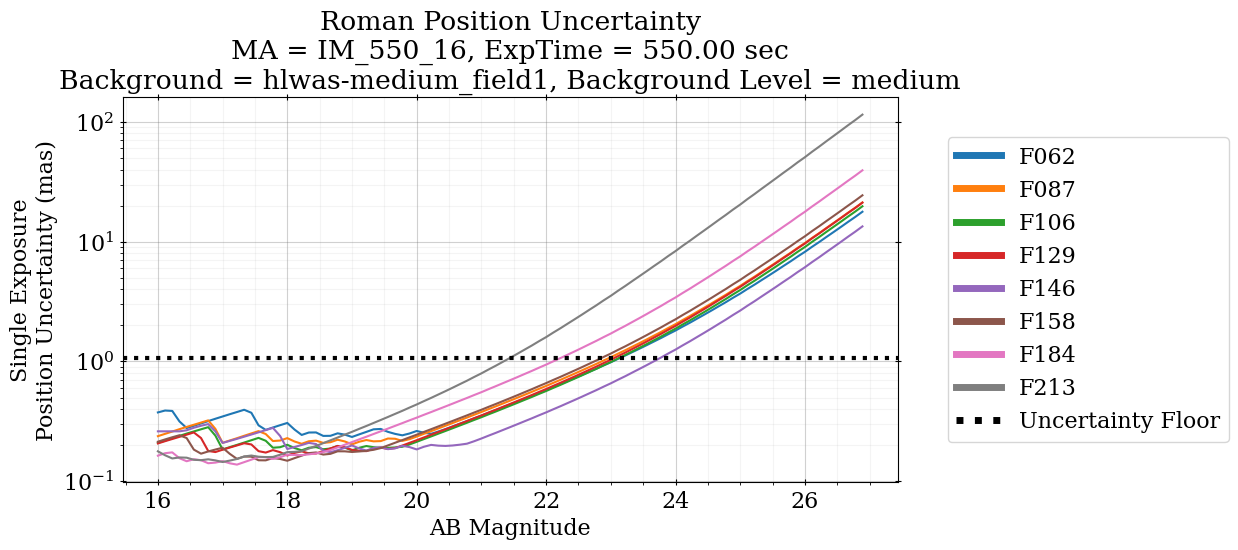

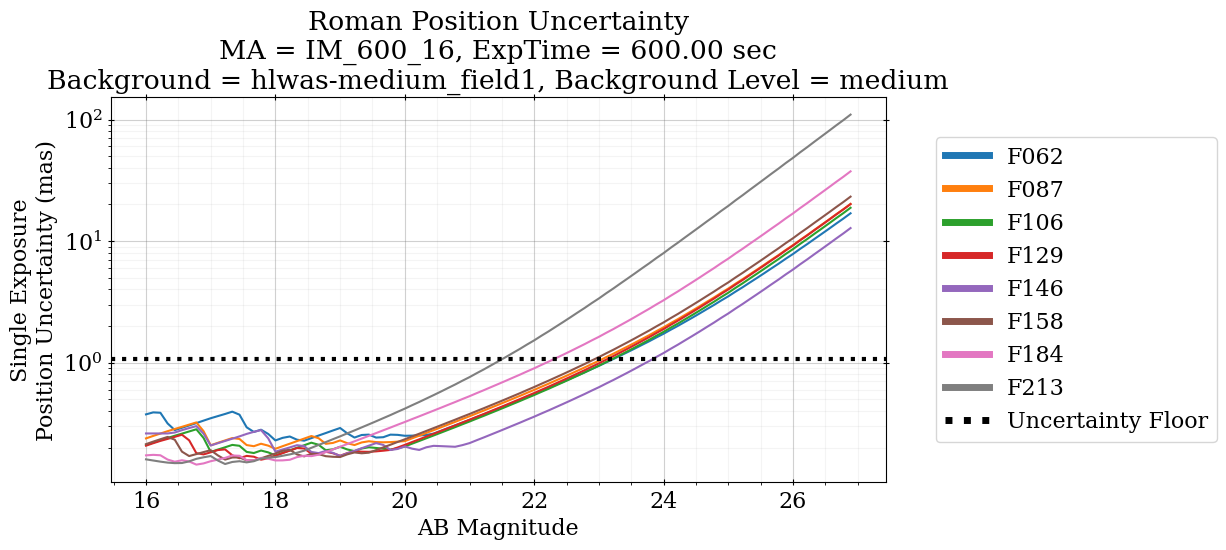

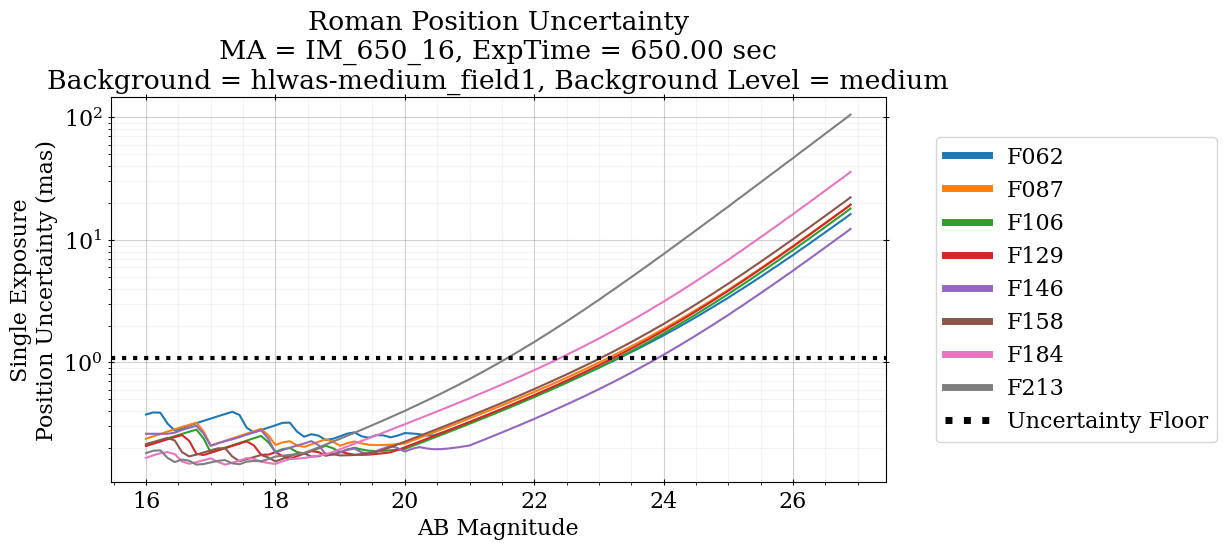

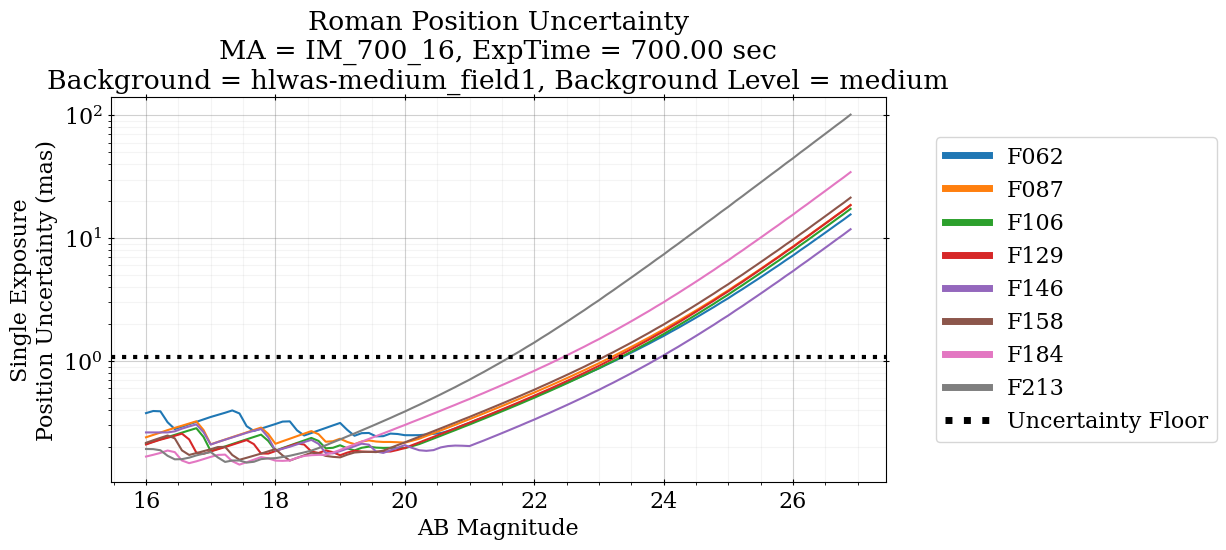

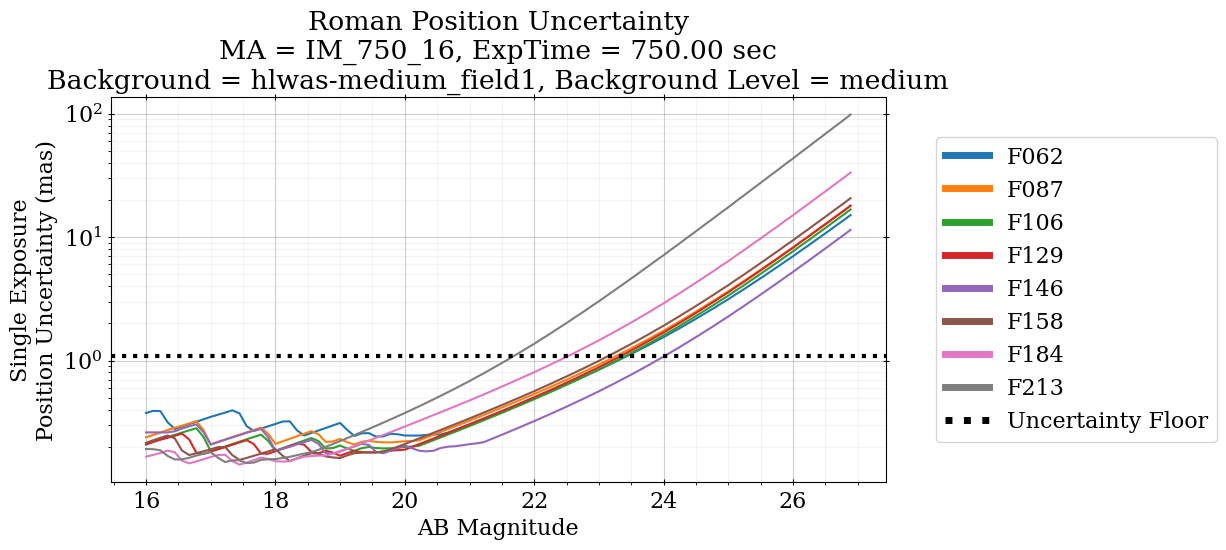

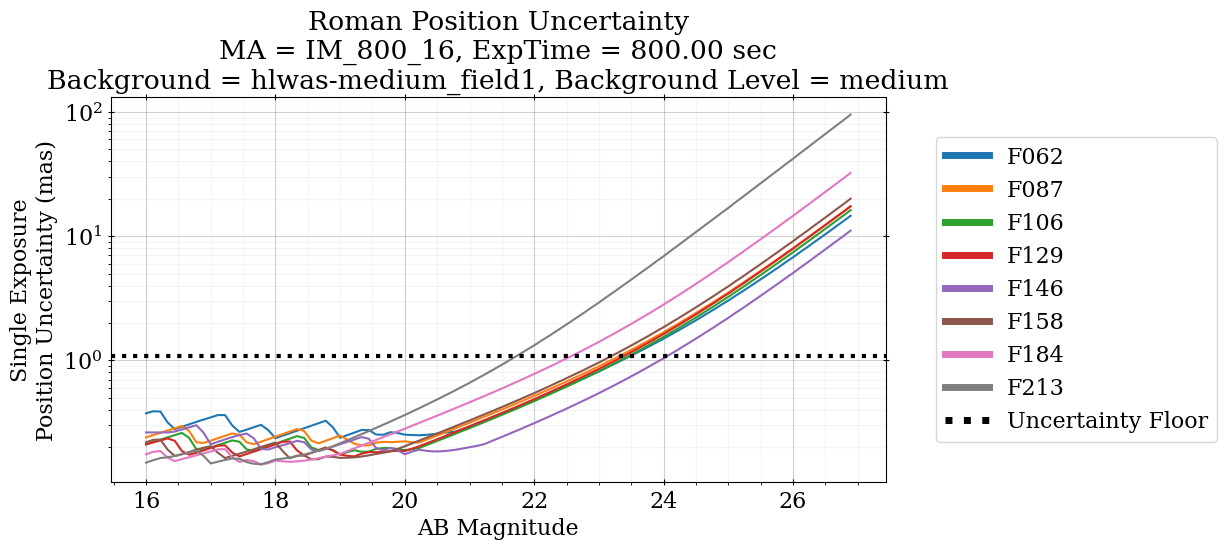

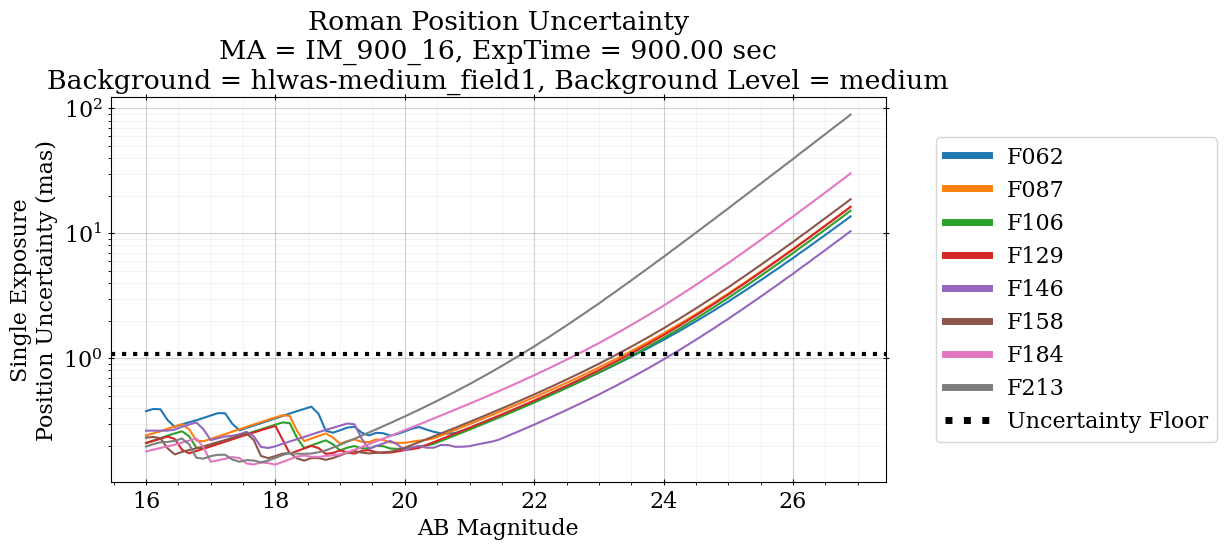

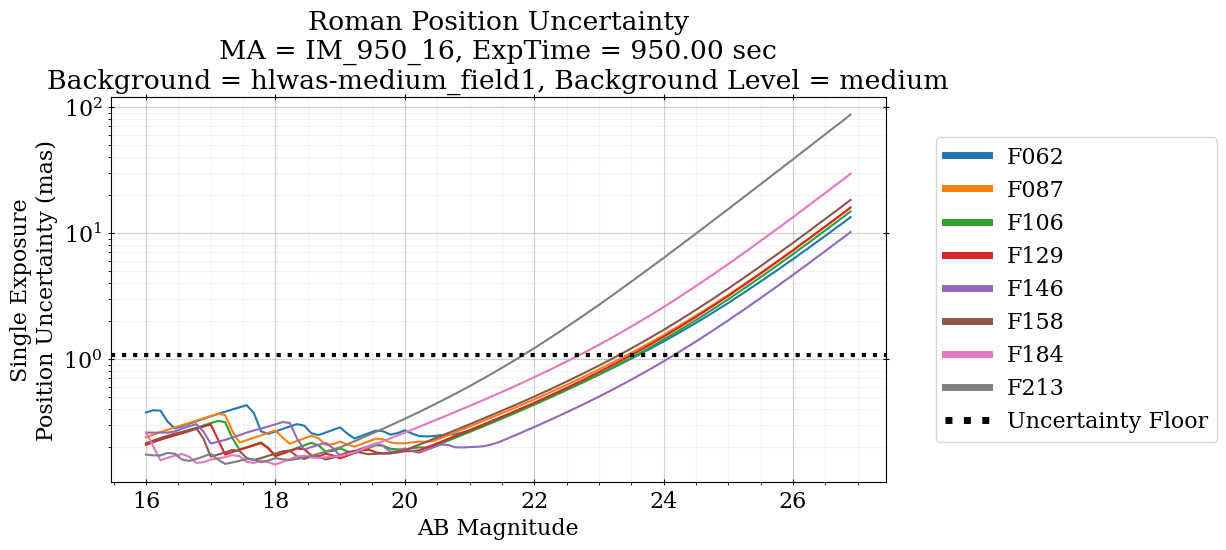

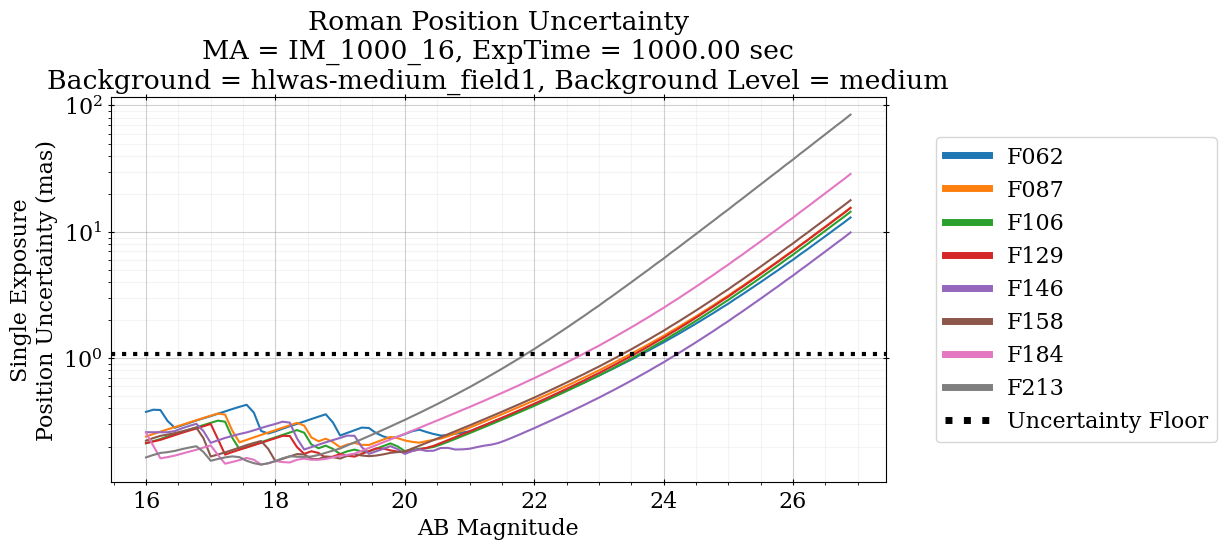

In [12]:
'''
Plot size of the position uncertainty (from a single observations) as a function
of AB magnitude for different Roman filters and different exposure times.
'''


mags_ab = np.linspace(16,27,100)

for ma_name in grc.allowed_ma_names:
    plt.figure(figsize=(10,5))
    ax = plt.gca()
    ax.set_yscale('log')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
    ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
    plt.title(f'Roman Position Uncertainty\nMA = {ma_name}, ExpTime = {grc.ma_integration_times[ma_name]:.2f} sec'\
                +f'\nBackground = {roman_background}, Background Level = {roman_background_level}')
    plt.xlabel('AB Magnitude')
    plt.ylabel('Single Exposure\nPosition Uncertainty (mas)')
    for filt in grc.allowed_filters:
        curr_pos_errs = grc.roman_position_precision(mags_ab,filt,ma_name,roman_background,roman_background_level)
        plt.plot(mags_ab,curr_pos_errs,label=filt)
    plt.axhline(roman_pos_floor_err,c='k',ls=':',lw=3,label = 'Uncertainty Floor')
    leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
    for line in leg.get_lines():
        line.set_linewidth(5.0)
    plt.show()
